In [1]:
import glob
import pandas as pd
import numpy as np

In [2]:
well_productions = pd.read_csv("well productions/well production.csv")

In [3]:
well_productions.keys().unique()

Index(['Unnamed: 0', 'well name', 'average pressure (Pa)', 'oil 1', 'oil 2',
       'oil 3', 'oil 4', 'oil 5', 'oil 6', 'oil 7', 'oil 8', 'oil 9', 'oil 10',
       'oil 11', 'oil 12', 'water 1', 'water 2', 'water 3', 'water 4',
       'water 5', 'water 6', 'water 7', 'water 8', 'water 9', 'water 10',
       'water 11', 'water 12'],
      dtype='object')

### Read in all the datas

In [4]:
import csv
datas = []
for file in glob.glob("well productions/*"):
    if "well production.csv" not in file:
        frame = pd.read_csv(file)
        # Strip off the extra things on the end
        frame["Name"] = file[17:-4]
        datas.append(frame)

In [5]:
def well_length(dataframe: pd.DataFrame):
    dataframe["well length"] = dataframe["easting"].iloc[-1] - dataframe["easting"][0]

In [6]:
def frac_stages(dataframe : pd.DataFrame):
    dataframe["frac stages"] = dataframe[dataframe["proppant weight (lbs)"].isna() == False].shape[0]

In [7]:
"""
Sets a proppant per stage as "ppf" defaults to the maximum weight
"""
def propant_per_stage(dataframe: pd.DataFrame, find_min=False):
    if find_min:
        val = min(dataframe["proppant weight (lbs)"])
    else:
        val = max(dataframe["proppant weight (lbs)"])
    dataframe["ppf"] = val

In [8]:
"""
Sets a pump rate as "pr" defaults to the maximum weight
"""
def pump_rate(dataframe: pd.DataFrame, find_min=False):
    if find_min:
        val = min(dataframe["pump rate (cubic feet/min)"])
    else:
        val = max(dataframe["pump rate (cubic feet/min)"])
    dataframe["pr"] = val

In [9]:
def original_oil_in_place(dataframe: pd.DataFrame):
    val = 0
    row = well_productions[well_productions["well name"] == dataframe["Name"][0]];
    for i in range(12):
        print(row)
        val += row[f"oil {i+1}"][row.index[0]]
    print(val)
    dataframe["ooip"] = val

In [10]:
def find_prodcution(dataframe: pd.DataFrame):
    pass

In [11]:
%%capture
list(map(well_length, datas))
list(map(frac_stages, datas))

# optional

In [12]:
%%capture
list(map(propant_per_stage, datas))
list(map(pump_rate, datas))
list(map(original_oil_in_place, datas))

In [13]:
datas[0].head()

,easting,northing,porosity,permeability,Poisson's ratio,Young's Modulus,water saturation,oil saturation,proppant weight (lbs),pump rate (cubic feet/min),Name,well length,frac stages,ppf,pr,ooip
0,41700.0,99100.0,0.04,0.006,0.301,9391150.736,0.206423,0.793577,957450.525302,269.739431,Brisket 1-204H,6974.0,50,1.660919e+06,384.966548,14080.0
1,41770.0,99100.0,0.03,0.004,0.301,9401124.957,0.206561,0.793439,NaN,NaN,Brisket 1-204H,6974.0,50,1.660919e+06,384.966548,14080.0
2,41841.0,99100.0,0.03,0.004,0.301,9401124.957,0.206561,0.793439,377282.535819,352.043256,Brisket 1-204H,6974.0,50,1.660919e+06,384.966548,14080.0
3,41911.0,99100.0,0.03,0.003,0.300,9411208.575,0.206701,0.793299,NaN,NaN,Brisket 1-204H,6974.0,50,1.660919e+06,384.966548,14080.0
4,41982.0,99100.0,0.03,0.002,0.300,9421399.932,0.206844,0.793156,89987.692337,300.275028,Brisket 1-204H,6974.0,50,1.660919e+06,384.966548,14080.0


In [14]:
big_df = pd.concat(datas)

In [15]:
big_df.to_csv("bigPoppa.csv", index=False)

In [16]:
test = pd.read_csv("bigPoppa.csv")

# Finding Cumulative Production

Exponential decline curve equation

    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [33]:
def exponential_loss(t, qi, D): 
    return qi*np.exp(-D*t)

def exponential_loss_list(qi, D): 
    t=life_of_res(qi, D)
    return qi*np.exp(-D*t)

def life_of_res(qi, D):
    return 1/D*np.log(qi/93)

def life_of_res_list(qi, D):
    #print(1/D*np.log(qi/93))
    return np.arange(1/D*np.log(qi/93), step=0.01)

In [42]:
def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))


def hyperbolic_equation_list(qi, b, di):
    t=life_of_res(qi, D)
    return qi/((1.0+b*di*t)**(1.0/b))



This function allows you to look at the first X months of production, and selects the highest production month as max initial production
    
    Arguments:
        number_first_months: int. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        
        well_name: String. name of the well where we're attempting to get
        the max volume from.

In [18]:
def get_max_initial_production(number_first_months, well_name):
    
    row = well_productions.loc[well_productions["well name"] == well_name]
    val=0      
    row = row.filter(regex='oil')
    row=row.T.squeeze()
    
    for i in range(number_first_months):
        val = max(row[i], val)

    return val, row

In [19]:


def get_cumulative(qi, D, q):
    return qi/D*np.log(qi/q)

# Note to self: *******make a for loop later*******



In [22]:
from scipy.optimize import curve_fit

#Exponential curve fit the data to get best fit equation
time_series=pd.Series(list(range(12)))
qi, row=get_max_initial_production(12, "Brisket 1-204H")

popt_exp, pcov_exp=curve_fit(exponential_loss, time_series, row, bounds=(0, [qi,20]))

D = popt_exp[1]

qi=popt_exp[0]

print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(D))

Exponential Fit Curve-fitted Variables: qi=1840.9999999999998, di=0.09389459383427125


In [41]:
#Hyperbolic curve fit the data to get best fit equation
time_series=pd.Series(list(range(12)))
qi, row=get_max_initial_production(12, "Brisket 1-204H")

popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, time_series, row,bounds=(0, [qi,2,20]))

print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))

Hyperbolic Fit Curve-fitted Variables: qi=1840.9999999377362, b=7.860138814184788e-09, di=0.0938969009724542


In [35]:
get_cumulative(qi, D, exponential_loss_list(qi, D)[-1])

58525.389999999985

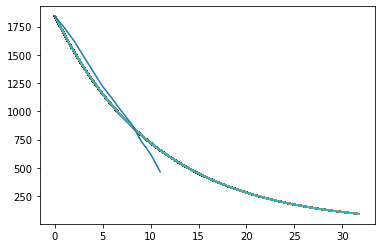

In [50]:
import matplotlib.pyplot as plt
x=np.linspace(0, life_of_res(qi, D), 20)
plt.plot(x, exponential_loss(x, qi, D))
plt.plot(time_series, row)
plt.show()